# Exploratory Analisys

## Context

This notebook aims to explore the linear structure of average  temperature over time as a preparatory step for building a hybrid forecast model. By analyzing trend, seasonal patterns and linear temporal dependence we seek to understand how much of the temperature variability can be explained by linear components. The non-linear structure will be analize in an second notebook.

**Data Source**
The data used in this notebook was extracted from the notebook *sanity-check.ipynb*

- **Data:** 16/08/2025
- **Localização:** ../data/wrangle

## Set up

### Libraries

In [1]:
## Base
import os
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Statistic
import scipy
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.quantile_regression import QuantReg

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[1].as_posix())

from src.ts_utils import *

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

## Data
For this project, the data are divided into four sets: train, validation, conformal prediction and test. To prevent information leakage into later stages, our exploratory analysis will initially focus exclusively on the train set.

In [4]:
df = pd.read_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_sanitized.parquet'))

weather_df = df.head(5 * 365).copy()

The data will be split as follows: 5 years for training, 2 years for validation, 2 years for conformal prediction and 1 year for testing.

In [5]:
display(weather_df.tail())
weather_df.info()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal
1820,2020-08-25,301.1,0.0,0.0,3.8,1015.5,7.2,Southeast
1821,2020-08-26,301.8,0.0,0.0,4.7,1013.2,10.5,Southwest
1822,2020-08-27,302.4,0.0,0.0,5.2,1010.0,10.6,Southwest
1823,2020-08-28,302.3,0.0,0.0,4.3,1006.1,10.6,Southwest
1824,2020-08-29,298.3,0.0,0.0,5.2,1007.1,8.9,Northwest


<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 0 to 1824
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       1825 non-null   datetime64[ns]
 1   tavg       1825 non-null   float64       
 2   prcp       1825 non-null   float64       
 3   snow       1825 non-null   float64       
 4   wspd       1825 non-null   float64       
 5   pres       1825 non-null   float64       
 6   tamp       1825 non-null   float64       
 7   wcardinal  1825 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(6)
memory usage: 116.2 KB


# Heteroscedastic
The first step is to address the seasonal heteroscedasticity in the data. To this end, we apply two classic variance-stabilizing transformations: logarithmic and Box–Cox, both designed to smooth the series and facilitate modeling. After transformation, we need to determine whether the transformed target or the original data is easier to forecast. To do this, we decompose the series into its seasonal and trend components before making a decision.

## Log Transformation

The logarithmic transformation is most effective when variability increases proportionally with the magnitude of the target. In our case, the relationship is inverse: variability decreases as the values increase. To account for this, we apply the transformation $log⁡(1/x)$, where $x$ represents the feature value.

In [6]:
def log_transf(serie: pd.Series):
    return serie.apply(lambda x: np.log(1/x))
def inv_log_transf(array: np.array):
    return 1/np.exp(array)

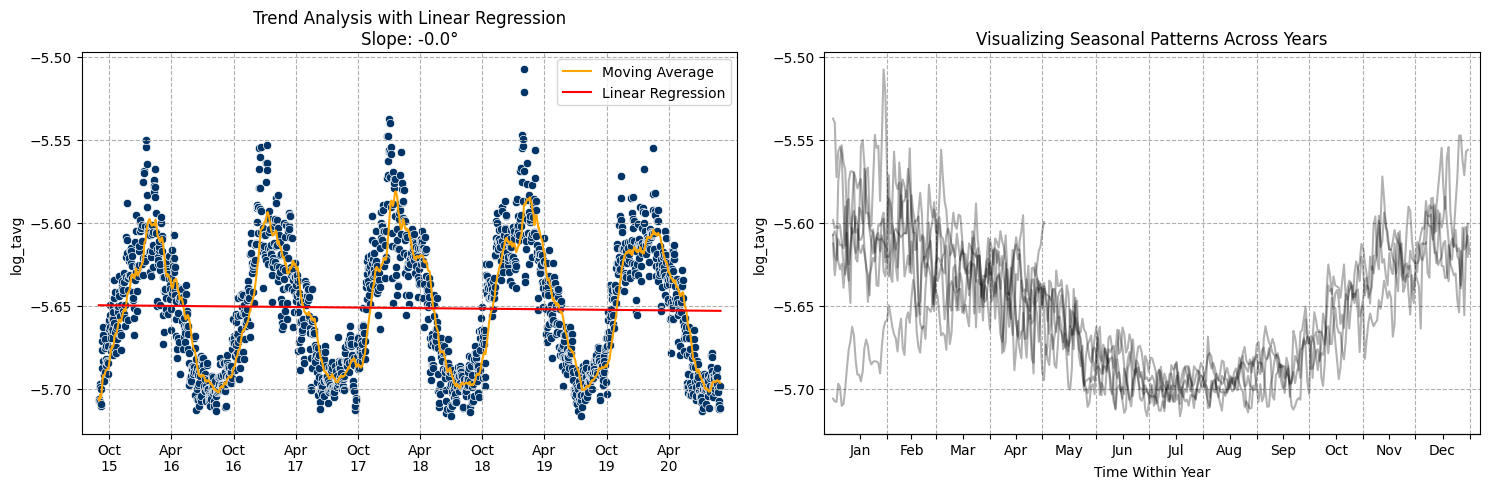

In [7]:
weather_df['log_tavg'] = log_transf(weather_df['tavg'])
ts_quick_insights(weather_df['log_tavg'], weather_df['time'])   

## Box-Cox Transformation
For the Box–Cox transformation, the same principle as for the logarithmic transformation applies. Therefore, we apply the Box–Cox transformation to $1/x$, where $x$ is the feature value. Unlike the logarithm, the Box–Cox transformation can automatically select an optimal power parameter $λ$ to stabilize variance, providing a more flexible approach to variance stabilization.

In [8]:
def box_transf(serie: pd.Series):
    return scipy.stats.boxcox(1/serie)
def inv_box_transf(serie: np.array, lmbda: float):
    return 1/scipy.special.inv_boxcox(serie, lmbda)

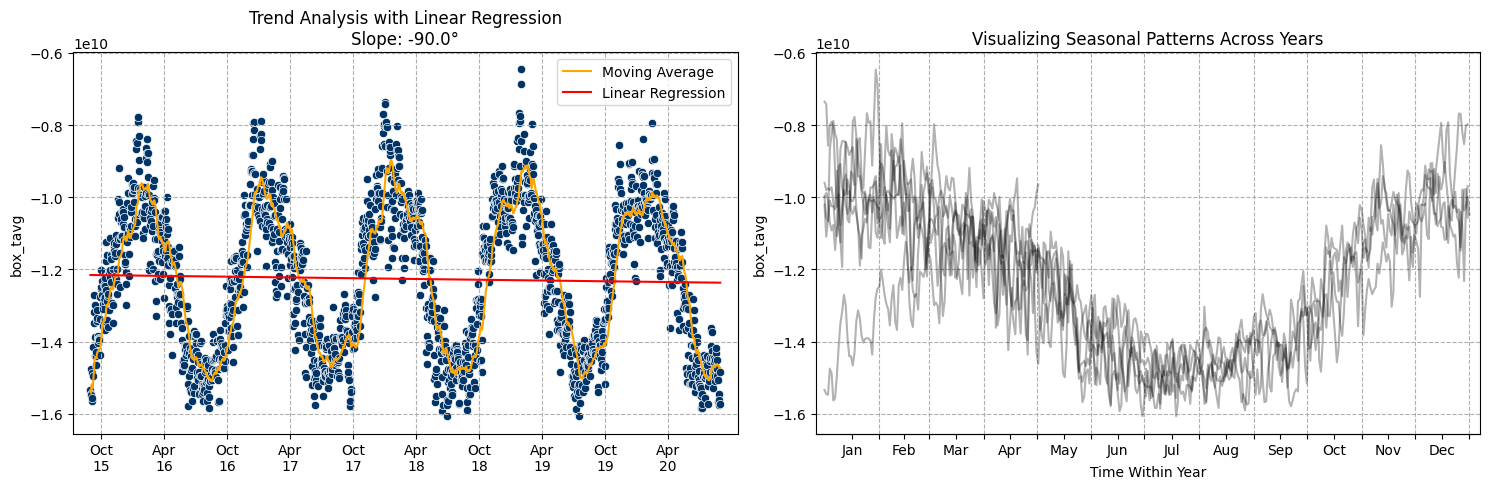

In [9]:
weather_df['box_tavg'], lmbda = box_transf(weather_df['tavg'])
ts_quick_insights(weather_df['box_tavg'], weather_df['time'])   

# Trend Decomposition
As observed in the plots, the slope of both the transformed and original data is approximately zero (or 90 degrees). Based on this, we can conclude that there is no discernible trend in any of the targets.

# Seasonal Decomposition
However, the data exhibit a clear annual seasonal pattern. Because this pattern is pronounced and we are addressing seasonal heteroscedasticity, we apply harmonic regression to model and remove the seasonal component. Additionally, to account for the heteroscedasticity, we use a quantile regression with $q=0.5$, as our main objective is to predict the temperature while minimizing the width of the prediction interval.

In [10]:
n = len(weather_df)
t = np.arange(n)

omega1 = (2 * np.pi / 365.25)
omega2 = 2 * (2 * np.pi / 365.25)
omega3 = 3 * (2 * np.pi / 365.25)

We include additional harmonic terms to ensure that all relevant seasonal patterns are captured, selecting those terms whose p-values indicate they are statistically significant for prediction ($< 0.05$).

In [11]:
residuals = pd.DataFrame() # Object to store the residuals

## Seasonal tavg
Despite the transformation, it is still premature to disregard the original data. Therefore, we will analyze it alongside the other variables on an equal footing.

In [12]:
y = weather_df['tavg'].copy()
X = np.column_stack([
    np.ones(n), # Intercept           
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

model = QuantReg(y, X)
res = model.fit(q=0.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   tavg   Pseudo R-squared:               0.6207
Model:                       QuantReg   Bandwidth:                       1.637
Method:                 Least Squares   Sparsity:                        10.04
Date:                Tue, 02 Sep 2025   No. Observations:                 1825
Time:                        11:37:59   Df Residuals:                     1818
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.9281      0.117   2425.542      0.000     284.698     285.158
x1            -8.2727      0.166    -49.815      0.000      -8.598      -7.947
x2            10.6719      0.166     64.217      0.000      10.346      10.998
x3            -0.3342      0.166     -2.013      0.044      -0.660      -0.009
x4             0.6025      0.166      3.626      0.000       0.277       0.928
x5             0.4444      0.166      2.676      0.008       0.119       0.770
x6            -0.1152      0.166     -0.693      0.488      -0.441       0.211
==============================================================================
"""

Using a 5% significance threshold, we determined that component 6 is not statistically significant. It is also important to note that component 3 is very close to the threshold. Since the differences are minimal, both components will be removed.

In [13]:
X = np.column_stack([
    np.ones(n), # Intercept           
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t),
    np.sin(omega3*t)
])

model = QuantReg(y, X)
res = model.fit(q=0.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   tavg   Pseudo R-squared:               0.6200
Model:                       QuantReg   Bandwidth:                       1.648
Method:                 Least Squares   Sparsity:                        10.08
Date:                Tue, 02 Sep 2025   No. Observations:                 1825
Time:                        11:37:59   Df Residuals:                     1820
                                        Df Model:                            4
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.9526      0.118   2416.122      0.000     284.721     285.184
x1            -8.4200      0.167    -50.500      0.000      -8.747      -8.093
x2            10.7146      0.167     64.219      0.000      10.387      11.042
x3             0.5930      0.167      3.554      0.000       0.266       0.920
x4             0.3736      0.167      2.240      0.025       0.047       0.701
==============================================================================
"""

Let’s examine the residuals to verify whether the regression has fitted the data as expected.

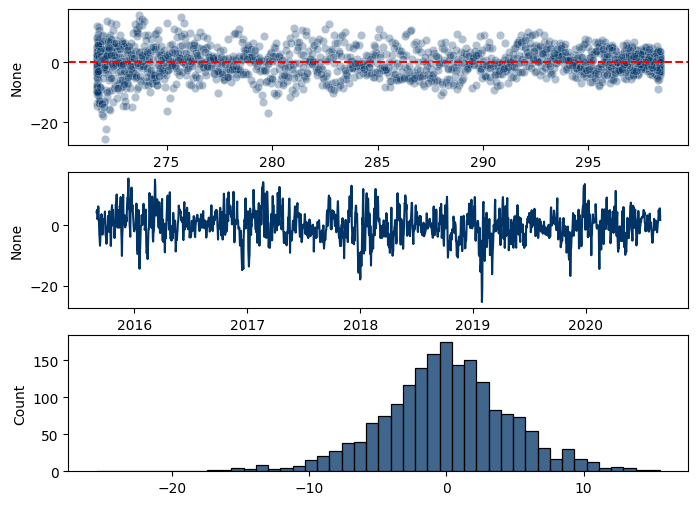

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.scatterplot(x=res.predict(X), y=res.resid, ax=ax[0], alpha=0.3)
ax[0].axhline(y=0, color='r', linestyle='--')

sns.lineplot(x=weather_df['time'], y=res.resid, ax=ax[1])

sns.histplot(res.resid, ax=ax[2])

plt.show()

As shown in the second plot, seasonal heteroscedasticity is still present in the residuals of the original data, as expected.

In [15]:
residuals['resid'] = res.resid

## Seasonal Log
Now, for the logarithmic transformation, we will examine it in the same way as the original variable.

In [16]:
log_y = weather_df['log_tavg'].copy()
log_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

log_model = QuantReg(log_y, log_X)
log_res = log_model.fit(q=0.5)
log_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               log_tavg   Pseudo R-squared:               0.6177
Model:                       QuantReg   Bandwidth:                    0.005722
Method:                 Least Squares   Sparsity:                      0.03506
Date:                Tue, 02 Sep 2025   No. Observations:                 1825
Time:                        11:37:59   Df Residuals:                     1818
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6517      0.000  -1.38e+04      0.000      -5.652      -5.651
x1             0.0291      0.001     50.118      0.000       0.028       0.030
x2            -0.0374      0.001    -64.489      0.000      -0.039      -0.036
x3             0.0006      0.001      1.096      0.273      -0.001       0.002
x4            -0.0020      0.001     -3.487      0.001      -0.003      -0.001
x5            -0.0016      0.001     -2.765      0.006      -0.003      -0.000
x6             0.0004      0.001      0.726      0.468      -0.001       0.002
==============================================================================
"""

As shown in the summary above, only the constant and components 1, 2, 4 and 5 are statistically useful for our regression.

In [17]:
log_y = weather_df['log_tavg'].copy()
log_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.cos(omega2*t),
    np.sin(omega3*t)
])


log_model = QuantReg(log_y, log_X)
log_res = log_model.fit(q=0.5)
log_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               log_tavg   Pseudo R-squared:               0.6174
Model:                       QuantReg   Bandwidth:                    0.005733
Method:                 Least Squares   Sparsity:                      0.03502
Date:                Tue, 02 Sep 2025   No. Observations:                 1825
Time:                        11:37:59   Df Residuals:                     1820
                                        Df Model:                            4
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6517      0.000  -1.38e+04      0.000      -5.653      -5.651
x1             0.0293      0.001     50.648      0.000       0.028       0.030
x2            -0.0375      0.001    -64.731      0.000      -0.039      -0.036
x3            -0.0020      0.001     -3.440      0.001      -0.003      -0.001
x4            -0.0013      0.001     -2.231      0.026      -0.002      -0.000
==============================================================================
"""

As we did previously, let’s analyze the residuals.

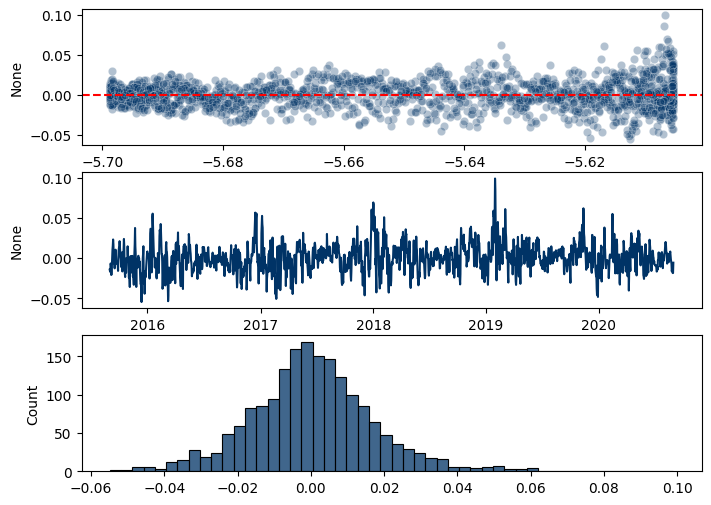

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.scatterplot(x=log_res.predict(log_X), y=log_res.resid, ax=ax[0], alpha=0.3)
ax[0].axhline(y=0, color='r', linestyle='--')

sns.lineplot(x=weather_df['time'], y=log_res.resid, ax=ax[1])

sns.histplot(log_res.resid, ax=ax[2])

plt.show()

As shown above, despite our efforts, the transformation was unable to eliminate the heteroscedasticity, which continues to be present in the residuals.

In [19]:
log_predict = inv_log_transf(log_res.predict(log_X))
residuals['log_resid'] = weather_df['tavg'] - log_predict

## Seasonal Box-Cox
The Box–Cox transformation has already been applied, and we will now run the harmonic regression on this transformed data, including all harmonic components.

In [20]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

box_model = QuantReg(box_y, box_X)
box_res = box_model.fit(q=0.5)
box_res.summary()

/home/pedro.moura/Pessoal/WeatherForecast/venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               box_tavg   Pseudo R-squared:               0.6292
Model:                       QuantReg   Bandwidth:                   3.128e+08
Method:                 Least Squares   Sparsity:                    1.889e+09
Date:                Tue, 02 Sep 2025   No. Observations:                 1825
Time:                        11:37:59   Df Residuals:                     1818
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.224e+10   2.21e+07   -553.585      0.000   -1.23e+10   -1.22e+10
x1          1.545e+09   3.13e+07     49.432      0.000    1.48e+09    1.61e+09
x2         -2.005e+09   3.13e+07    -64.092      0.000   -2.07e+09   -1.94e+09
x3          1.519e+08   3.13e+07      4.860      0.000    9.06e+07    2.13e+08
x4         -1.378e+08   3.13e+07     -4.406      0.000   -1.99e+08   -7.65e+07
x5         -6.918e+07   3.13e+07     -2.213      0.027    -1.3e+08   -7.88e+06
x6          2.032e+07   3.13e+07      0.650      0.516    -4.1e+07    8.17e+07
==============================================================================
"""

Unlike the regressions above, the statistically significant components here are the constant, 1, 2, 3, 4 and 5.

In [21]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t)
])

box_model = QuantReg(box_y, box_X)
box_res = box_model.fit(q=0.5, method='simplex', max_iter=100000)
box_res.summary()

/home/pedro.moura/Pessoal/WeatherForecast/venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (100000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               box_tavg   Pseudo R-squared:               0.6291
Model:                       QuantReg   Bandwidth:                   3.143e+08
Method:                 Least Squares   Sparsity:                    1.892e+09
Date:                Tue, 02 Sep 2025   No. Observations:                 1825
Time:                        11:38:15   Df Residuals:                     1819
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.225e+10   2.21e+07   -553.116      0.000   -1.23e+10   -1.22e+10
x1          1.543e+09   3.13e+07     49.287      0.000    1.48e+09     1.6e+09
x2         -2.003e+09   3.13e+07    -63.955      0.000   -2.06e+09   -1.94e+09
x3          1.526e+08   3.13e+07      4.874      0.000    9.12e+07    2.14e+08
x4         -1.403e+08   3.13e+07     -4.480      0.000   -2.02e+08   -7.89e+07
x5         -6.401e+07   3.13e+07     -2.045      0.041   -1.25e+08   -2.63e+06
==============================================================================
"""

Despite increasing the maximum number of iterations and testing multiple optimization methods, none were able to properly converge the coefficients. Therefore, the Quantile Regression for the Box–Cox–transformed data was disregarded, and we will instead apply OLS regression, as it tends to be more stable.

## Seasonal OLS Box-Cox
Here, we follow the same approach as before: we test multiple harmonic terms and retain only those that are statistically significant.

In [22]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t),
    np.cos(omega3*t)
])

box_model = sm.OLS(box_y, box_X)
box_res = box_model.fit()
box_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               box_tavg   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1428.
Date:                Tue, 02 Sep 2025   Prob (F-statistic):               0.00
Time:                        11:38:15   Log-Likelihood:                -40093.
No. Observations:                1825   AIC:                         8.020e+04
Df Residuals:                    1818   BIC:                         8.024e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.226e+10   1.97e+07   -621.750      0.000   -1.23e+10   -1.22e+10
x1           1.59e+09   2.79e+07     57.032      0.000    1.54e+09    1.64e+09
x2         -2.025e+09   2.79e+07    -72.573      0.000   -2.08e+09   -1.97e+09
x3          8.954e+07   2.79e+07      3.212      0.001    3.49e+07    1.44e+08
x4         -1.556e+08   2.79e+07     -5.578      0.000    -2.1e+08   -1.01e+08
x5         -7.839e+07   2.79e+07     -2.812      0.005   -1.33e+08   -2.37e+07
x6          2.905e+07   2.79e+07      1.041      0.298   -2.57e+07    8.38e+07
==============================================================================
Omnibus:                       11.023   Durbin-Watson:                   0.572
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.249
Skew:                          -0.102   Prob(JB):                      0.00133
Kurtosis:                       3.365   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Unlike in the quantile regression, only harmonic terms 1, 2, 4 and 5 were found to be relevant.

In [23]:
box_y = weather_df['box_tavg'].copy()
box_X = np.column_stack([
    np.ones(n),                 
    np.sin(omega1*t),
    np.cos(omega1*t),
    np.sin(omega2*t),
    np.cos(omega2*t),
    np.sin(omega3*t)
])

box_model = sm.OLS(box_y, box_X)
box_res = box_model.fit()
box_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               box_tavg   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1713.
Date:                Tue, 02 Sep 2025   Prob (F-statistic):               0.00
Time:                        11:38:15   Log-Likelihood:                -40094.
No. Observations:                1825   AIC:                         8.020e+04
Df Residuals:                    1819   BIC:                         8.023e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.226e+10   1.97e+07   -621.737      0.000   -1.23e+10   -1.22e+10
x1           1.59e+09   2.79e+07     57.031      0.000    1.54e+09    1.64e+09
x2         -2.025e+09   2.79e+07    -72.573      0.000   -2.08e+09   -1.97e+09
x3          8.954e+07   2.79e+07      3.212      0.001    3.49e+07    1.44e+08
x4         -1.557e+08   2.79e+07     -5.579      0.000    -2.1e+08   -1.01e+08
x5         -7.839e+07   2.79e+07     -2.812      0.005   -1.33e+08   -2.37e+07
==============================================================================
Omnibus:                       10.816   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.117
Skew:                          -0.096   Prob(JB):                      0.00142
Kurtosis:                       3.368   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With the regression trained, we now examine the residuals and save the data for subsequent analysis.

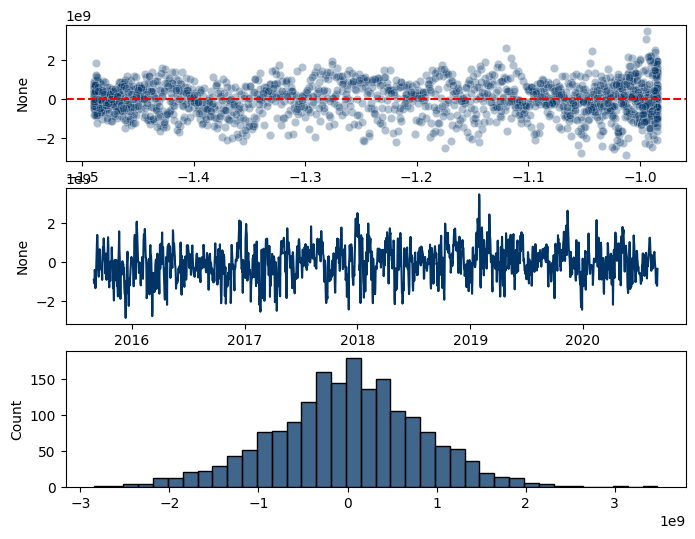

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

sns.scatterplot(x=box_res.predict(box_X), y=box_res.resid, ax=ax[0], alpha=0.3)
ax[0].axhline(y=0, color='r', linestyle='--')

sns.lineplot(x=weather_df['time'], y=box_res.resid, ax=ax[1])

sns.histplot(box_res.resid, ax=ax[2])

plt.show()

Based on the residual plots, the Box–Cox transformation appears to handle heteroscedasticity better than the other transformations. However, this assessment is currently purely visual. To confirm, we will perform the Breusch–Pagan test to formally evaluate whether heteroscedasticity persists, using a 5% significance level to determine rejection of the null hypothesis.

- **Null hypothesis**: Residuals are homoscedastic.
- **Alternativa hypothesis**: Heteroscedasticity present.

In [25]:
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(box_res.resid, box_X)
f_pvalue

np.float64(4.604538338882409e-17)

From the test above, we reject the null hypothesis, indicating that heteroscedasticity is still present. However, visually the heteroscedasticity appears less pronounced than in the other variables. The other residuals exhibit more prominent seasonal peaks and troughs, highlighting stronger seasonal heteroscedasticity compared to the Box–Cox–transformed data

In [26]:
box_predict = inv_box_transf(box_res.predict(box_X), lmbda)
residuals['box_resid'] = weather_df['tavg'] - box_predict

# Residuals Analysis
Now, let us examine the residuals to determine which method best fits our objective. The primary metric will be the interquartile range (IQR), chosen for its direct relationship with the width of the prediction interval, which we aim to minimize.

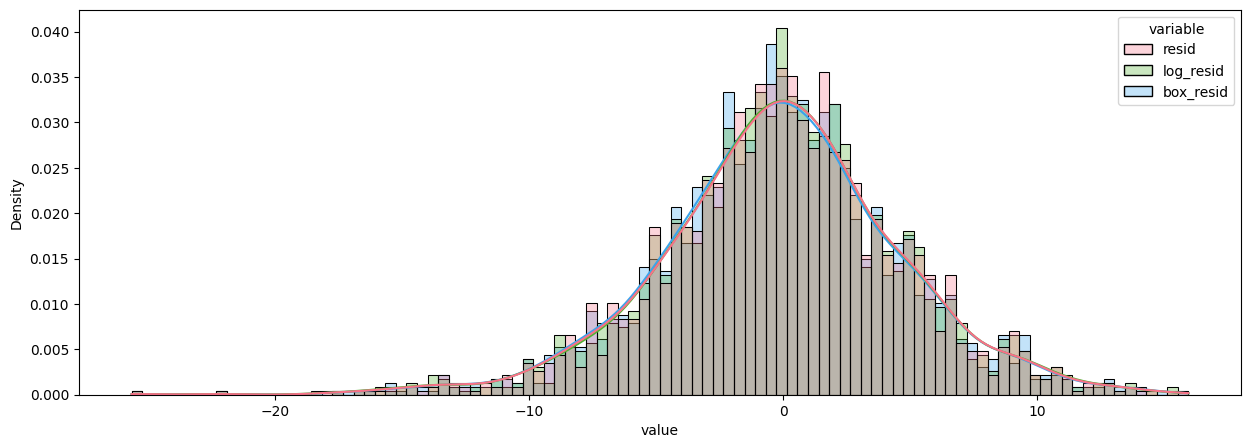

value                                                         \
            count      mean       std        min       25%           50%   
variable                                                                   
box_resid  1825.0 -0.135437  4.759898 -25.571247 -2.913235 -1.309003e-01   
log_resid  1825.0 -0.067533  4.764070 -25.643403 -2.815249 -8.820660e-05   
resid      1825.0 -0.070952  4.760802 -25.486878 -2.796001 -3.558661e-07   

                                     IQR  
                75%        max            
variable                                  
box_resid  2.624337  15.957267  5.537572  
log_resid  2.684432  15.446886  5.499681  
resid      2.709118  15.590907  5.505118

In [27]:
df_resid = residuals.melt()

plt.figure(figsize=(15, 5))
sns.histplot(data=df_resid, x='value', hue='variable', stat='density', bins=100, kde=True, alpha=0.3)
plt.show()

desc_resid = df_resid.groupby('variable').describe()
desc_resid['IQR'] = desc_resid[('value',   '75%')] - desc_resid[('value',   '25%')]
desc_resid

Although the Box–Cox transformation appeared to handle heteroscedasticity most effectively, it yielded the weakest predictive performance, showing both the highest IQR and the largest average residual error. The logarithmic transformation resulted in a slightly lower mean and IQR, but the improvement was too small to justify its use. Therefore, the raw residuals will be used.

In [28]:
weather_df['y_hat'] = res.predict(X)
weather_df['resid'] = res.resid
weather_df.head()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal,log_tavg,box_tavg,y_hat,resid
0,2015-09-01,300.6,0.0,0.0,3.8,1015.8,8.4,South,-5.705780,-1.533923e+10,296.260237,4.339763
1,2015-09-02,301.1,0.0,0.0,3.6,1015.0,10.5,Southwest,-5.707442,-1.545101e+10,296.132733,4.967267
2,2015-09-03,301.2,0.0,0.0,4.2,1012.4,10.6,Southwest,-5.707774,-1.547344e+10,296.001348,5.198652
3,2015-09-04,297.9,0.0,0.0,2.9,1015.0,8.5,Southwest,-5.696758,-1.474633e+10,295.866078,2.033922
4,2015-09-05,298.5,0.0,0.0,3.1,1017.6,7.9,South,-5.698770,-1.487653e+10,295.726918,2.773082


# Conclusion

In [29]:
DATA_PATH_WRANGLE.mkdir(parents=True, exist_ok=True)
weather_df.drop(columns=['log_tavg', 'box_tavg']).to_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_linear_resids.parquet'))